<a href="https://colab.research.google.com/github/tuongkhangduongle/2021-datascience-lectures-utah-uni/blob/master/week_01/lab_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PYTORCH TUTORIAL

## 1. Demo dataset - MNIST

### 1.1 Download data

We will use the classic MNIST dataset, which consists of black-and-white images of hand-drawn digits (between 0 and 9).

We will use `pathlib` for dealing with paths (part of the Python 3 standard library), and will download the dataset using requests. We will only import modules when we use them, so you can see exactly what’s being used at each point.

In [109]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
  ##################
  # Download dataset
  # CODE HERE
  content = requests.get(URL+FILENAME).content
  (PATH / FILENAME).open('wb').write(content)
  #
  ##################

This dataset is in numpy array format, and has been stored using pickle, a python-specific format for serializing data.

In [110]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
  ##################
  # Load dataset
  # CODE HERE
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding = 'latin-1')
  
  #
  ##################

### 1.2 Visualize data

Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28). Let’s take a look at one; we need to reshape it to 2d first.

label:  5


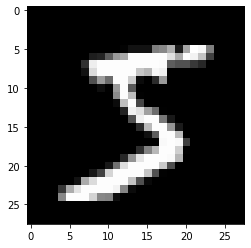

In [111]:
from matplotlib import pyplot
import numpy as np

##################
# Use matplotlib to visualize sample image
# CODE HERE
pyplot.imshow(x_train[0].reshape((28,28)), cmap = 'gray')
print('label: ', y_train[0])

#
##################

In [112]:
##################
# Show train shape
# CODE HERE
print(x_train.shape)

#
##################

(50000, 784)


### 1.3 PyTorch Tensor

PyTorch uses `torch.tensor`, rather than numpy arrays, so we need to convert our data.

In [113]:
import torch

##################
# Convert numpy array to torch.tensor
# CODE 
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n,c = x_train.shape

#
##################

In [114]:
##################
# Show torch.tensor properties
# CODE HERE
print("xtrain: ", x_train)
print('ytrain', y_train)
print('shape of x_train:', x_train.shape)
print()
print(y_train.min(), y_train.max())

#
##################

xtrain:  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
ytrain tensor([5, 0, 4,  ..., 8, 4, 8])
shape of x_train: torch.Size([50000, 784])

tensor(0) tensor(9)


## 2. Neural net from scratch (no torch.nn)

### 2.1 Create a simple linear model

PyTorch provides methods to create random or zero-filled tensors, which we will use to create our weights and bias for a simple linear model. These are just regular tensors, with one very special addition: we tell PyTorch that they require a gradient. This causes PyTorch to record all of the operations done on the tensor, so that it can calculate the gradient during back-propagation automatically!

For the weights, we set `requires_grad` **after** the initialization, since we don’t want that step included in the gradient. (Note that a trailing `_` in PyTorch signifies that the operation is performed in-place.)

In [131]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Thanks to PyTorch’s ability to calculate gradients automatically, we can use any standard Python function (or callable object) as a model! So let’s just write a plain matrix multiplication and broadcasted addition to create a simple linear model. We also need an activation function, so we’ll write `log_softmax` and use it.

**Remember:** although PyTorch provides lots of pre-written loss functions, activation functions, and so forth, you can easily write your own using plain python. PyTorch will even create fast GPU or vectorized CPU code for your function automatically.

In [116]:
def log_softmax(x):
  ##################
  # Use pytorch function to create softmax function
  # CODE HERE
  return x - x.exp().sum(-1).log().unsqueeze(-1)
  #
  ##################

def model(xb):
  return log_softmax(xb @ weights + bias)
# @ operation for produce of 2 matrixes

In the above, the `@` stands for the matrix multiplication operation.

### 2.2 Predict

We will call our function on one batch of data (in this case, 64 images). This is one forward pass. Note that our predictions won’t be any better than random at this stage, since we start with random weights.

In [117]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
print(preds[0], preds.shape)

tensor([-2.2710, -1.6262, -2.3080, -2.3935, -2.5060, -2.3691, -2.3058, -2.8403,
        -2.4560, -2.4043], grad_fn=<SelectBackward0>) torch.Size([64, 10])


As you see, the `preds` tensor contains not only the tensor values, but also a gradient function. We’ll use this later to do backprop.

### 2.3 Loss

Let’s implement negative log-likelihood to use as the loss function (again, we can just use standard Python):

In [118]:
def nll(input, target):
  return -input[range(target.shape[0]), target].mean()

loss_func = nll

Let’s check our loss with our random model, so we can see if we improve after a backprop pass later.

In [119]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.2465, grad_fn=<NegBackward0>)


### 2.4 Evaluate

Let’s also implement a function to calculate the accuracy of our model. For each prediction, if the index with the largest value matches the target value, then the prediction was correct.

In [120]:
def accuracy(out, yb):
  ##################
  # Use pytorch function to create accuracy function
  # CODE HERE
  cnt = 0
  for i in range(len(yb)):
      if torch.argmax(out[i]).item() == yb[i].item():
          cnt+=1
  return cnt/len(yb)
  #
  ##################

Let’s check the accuracy of our random model, so we can see if our accuracy improves as our loss improves.

In [121]:
print(accuracy(preds, yb))

0.125


### 2.5 Training loop

We can now run a training loop. For each iteration, we will:

- select a mini-batch of data (of size bs)
- use the model to make predictions
- calculate the loss
- `loss.backward()` updates the gradients of the model, in this case, weights and bias.

We now use these gradients to update the weights and bias. We do this within the `torch.no_grad()` context manager, because we do not want these actions to be recorded for our next calculation of the gradient. You can read more about how PyTorch’s Autograd records operations here.

We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. `loss.backward()` adds the gradients to whatever is already stored, rather than replacing them).

**Tip:** You can use the standard python debugger to step through PyTorch code, allowing you to check the various variable values at each step. Uncomment set_trace() below to try it out.

In [137]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
  for i in range((n - 1) // bs + 1):
    # set_trace()
    start_i = i * bs
    end_i = start_i + bs
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
  
    pred = model(xb)
  
    loss = loss_func(pred, yb)

    loss.backward()
  
    with torch.no_grad():
      ##################
      # Update weights and bias by gradient descent algorithm
      # CODE HERE
      
      weights -= weights.grad * lr
      bias -= bias.grad *lr
      weights.grad.zero_() 
      bias.grad.zero_()
      #
      ##################

That’s it: we’ve created and trained a minimal neural network (in this case, a logistic regression, since we have no hidden layers) entirely from scratch!

Let’s check the loss and accuracy and compare those to what we got earlier. We expect that the loss will have decreased and accuracy to have increased, and they have.

In [138]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0661, grad_fn=<NllLossBackward0>) 1.0


## 3. Using torch.nn.functional

We will now refactor our code, so that it does the same thing as before, only we’ll start taking advantage of PyTorch’s `nn` classes to make it more concise and flexible. At each step from here, we should be making our code one or more of: shorter, more understandable, and/or more flexible.

The first and easiest step is to make our code shorter by replacing our hand-written activation and loss functions with those from `torch.nn.functional` (which is generally imported into the namespace `F` by convention). This module contains all the functions in the `torch.nn` library (whereas other parts of the library contain classes). As well as a wide range of loss and activation functions, you’ll also find here some convenient functions for creating neural nets, such as pooling functions. (There are also functions for doing convolutions, linear layers, etc, but as we’ll see, these are usually better handled using other parts of the library.)

If you’re using negative log likelihood loss and log softmax activation, then Pytorch provides a single function `F.cross_entropy` that combines the two. So we can even remove the activation function from our model.

In [139]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
  ##################
  # Create simple fully connected neural network
  # CODE HERE
  return xb@weights + bias
  #
  ##################

Note that we no longer call `log_softmax` in the `model` function. Let’s confirm that our loss and accuracy are the same as before:

In [140]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0661, grad_fn=<NllLossBackward0>) 1.0


## 4. Using torch.nn.Module

Next up, we'll use `nn.Module` and `nn.Parameter`, for a clearer and more
concise training loop. We subclass `nn.Module` (which itself is a class and
able to keep track of state). In this case, we want to create a class that
holds our weights, bias, and method for the forward step. `nn.Module` has a
number of attributes and methods (such as `.parameters()` and `.zero_grad()`)
which we will be using.

In [189]:
from torch import nn

class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    ##################
    # Create random weights and bias
    # CODE HERE
    self.weights = nn.Parameter(torch.randn(784,10)/math.sqrt(784))
    self.bias = nn.Parameter(torch.zeros(10))
    #
    ##################

  def forward(self, xb):
    ##################
    # Create forward function
    # CODE HERE
    return xb@self.weights + self.bias
    #
    ##################

Since we're now using an object instead of just using a function, we
first have to instantiate our model:

In [190]:
model = Mnist_Logistic()

Now we can calculate the loss in the same way as before. Note that
`nn.Module` objects are used as if they are functions (i.e they are
*callable*), but behind the scenes Pytorch will call our `forward`
method automatically.

In [144]:
print(loss_func(model(xb), yb))

tensor(2.4809, grad_fn=<NllLossBackward0>)


Previously for our training loop we had to update the values for each parameter
by name, and manually zero out the grads for each parameter separately, like this:

```
with torch.no_grad():
  weights -= weights.grad * lr
  bias -= bias.grad * lr
  weights.grad.zero_()
  bias.grad.zero_()
```

Now we can take advantage of `model.parameters()` and `model.zero_grad()` (which
are both defined by PyTorch for `nn.Module`) to make those steps more concise
and less prone to the error of forgetting some of our parameters, particularly
if we had a more complicated model:


```
with torch.no_grad():
  for p in model.parameters(): p -= p.grad * lr
  model.zero_grad()
```


We'll wrap our little training loop in a `fit` function so we can run it
again later.



In [147]:
def fit():
  for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
      start_i = i * bs
      end_i = start_i + bs
      xb = x_train[start_i:end_i]
      yb = y_train[start_i:end_i]
      pred = model(xb)
      loss = loss_func(pred, yb)

      loss.backward()
      with torch.no_grad():
        for p in model.parameters():
          ##################
          # Update weights and bias
          # CODE HERE
          p -= p.grad * lr
          pass
          #
          ##################
        model.zero_grad()

fit()

In [148]:
print(loss_func(model(xb), yb))

tensor(0.0647, grad_fn=<NllLossBackward0>)


We continue to refactor our code.  Instead of manually defining and
initializing ``self.weights`` and ``self.bias``, and calculating ``xb  @
self.weights + self.bias``, we will instead use the Pytorch class
`nn.Linear <https://pytorch.org/docs/stable/nn.html#linear-layers>`_ for a
linear layer, which does all that for us. Pytorch has many types of
predefined layers that can greatly simplify our code, and often makes it
faster too.

In [191]:
class Mnist_Logistic_v2(nn.Module):
    def __init__(self):
        super().__init__()
    ##################
    # Use torch.nn.Linear instead of weights and bias
    # CODE HERE
        self.lin == nn.Linear(784, 10)
    #
    ##################
    def forward(self, xb):
        return self.lin(xb)

We instantiate our model and calculate the loss in the same way as before:

In [195]:
model = Mnist_Logistic_v2()
print(loss_func(model(xb), yb))

AttributeError: ignored

We are still able to use our same `fit` method as before.

In [160]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0594, grad_fn=<NllLossBackward0>)


## 5. Using torch.optim

Pytorch also has a package with various optimization algorithms, `torch.optim`.
We can use the `step` method from our optimizer to take a forward step, instead
of manually updating each parameter.

This will let us replace our previous manually coded optimization step:

```
with torch.no_grad():
  for p in model.parameters(): p -= p.grad * lr
  model.zero_grad()
```

and instead use just:

```
opt.step()
opt.zero_grad()
```

(`optim.zero_grad()` resets the gradient to 0 and we need to call it before
computing the gradient for the next minibatch.)

In [172]:
from torch import optim

def get_model():
  model = Mnist_Logistic()
  return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
  for i in range((n - 1) // bs + 1):
    start_i = i * bs
    end_i = start_i + bs
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2830, grad_fn=<NllLossBackward0>)
tensor(0.0821, grad_fn=<NllLossBackward0>)


## 6. Using Dataset and DataLoader

PyTorch has an abstract Dataset class.  A Dataset can be anything that has
a `__len__` function (called by Python's standard ``len`` function) and
a `__getitem__` function as a way of indexing into it.
`This tutorial <https://pytorch.org/tutorials/beginner/data_loading_tutorial.html>`_
walks through a nice example of creating a custom `FacialLandmarkDataset` class
as a subclass of `Dataset`.

PyTorch's `TensorDataset <https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset>`_
is a Dataset wrapping tensors. By defining a length and way of indexing,
this also gives us a way to iterate, index, and slice along the first
dimension of a tensor. This will make it easier to access both the
independent and dependent variables in the same line as we train.

In [173]:
from torch.utils.data import TensorDataset

Both `x_train` and `y_train` can be combined in a single `TensorDataset`,
which will be easier to iterate over and slice.

In [174]:
train_ds = TensorDataset(x_train, y_train)

Previously, we had to iterate through minibatches of x and y values separately:

```
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]
```

Now, we can do these two steps together:

```
xb,yb = train_ds[i*bs : i*bs+bs]
```

In [175]:
model, opt = get_model()

for epoch in range(epochs):
  for i in range((n - 1) // bs + 1):
    xb, yb = train_ds[i * bs: i * bs + bs]
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0813, grad_fn=<NllLossBackward0>)


Pytorch's `DataLoader` is responsible for managing batches. You can
create a `DataLoader` from any `Dataset`. `DataLoader` makes it easier
to iterate over batches. Rather than having to use `train_ds[i*bs : i*bs+bs]`,
the DataLoader gives us each minibatch automatically.

In [176]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [177]:
model, opt = get_model()

for epoch in range(epochs):
  for xb, yb in train_dl:
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0819, grad_fn=<NllLossBackward0>)


## 7. Add Validation and create `fit()`, `get_data()`

Before, we were just trying to get a reasonable training loop set up for
use on our training data.  In reality, you **always** should also have
a `validation set <https://www.fast.ai/2017/11/13/validation-sets/>`_, in order
to identify if you are overfitting.

Shuffling the training data is
`important <https://www.quora.com/Does-the-order-of-training-data-matter-when-training-neural-networks>`_
to prevent correlation between batches and overfitting. On the other hand, the
validation loss will be identical whether we shuffle the validation set or not.
Since shuffling takes extra time, it makes no sense to shuffle the validation data.

We'll use a batch size for the validation set that is twice as large as
that for the training set. This is because the validation set does not
need backpropagation and thus takes less memory (it doesn't need to
store the gradients). We take advantage of this to use a larger batch
size and compute the loss more quickly.

In [178]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()`
before inference, because these are used by layers such as `nn.BatchNorm2d`
and `nn.Dropout` to ensure appropriate behaviour for these different phases.)



In [179]:
model, opt = get_model()

for epoch in range(epochs):
  model.train()
  for xb, yb in train_dl:
    pred = model(xb)
    loss = loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

  model.eval()
  with torch.no_grad():
    valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

  print(epoch, valid_loss / len(valid_dl))

0 tensor(0.2940)
1 tensor(0.3026)


We'll now do a little refactoring of our own. Since we go through a similar
process twice of calculating the loss for both the training set and the
validation set, let's make that into its own function, ``loss_batch``, which
computes the loss for one batch.

We pass an optimizer in for the training set, and use it to perform
backprop.  For the validation set, we don't pass an optimizer, so the
method doesn't perform backprop.

In [180]:
def loss_batch(model, loss_func, xb, yb, opt=None):
  loss = loss_func(model(xb), yb)

  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()

  return loss.item(), len(xb)

`fit` runs the necessary operations to train our model and compute the
training and validation losses for each epoch.

In [181]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      loss_batch(model, loss_func, xb, yb, opt)

    model.eval()
    with torch.no_grad():
      losses, nums = zip(
        *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
      )
    val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

    print(epoch, val_loss)

`get_data` returns dataloaders for the training and validation sets.

In [182]:
def get_data(train_ds, valid_ds, bs):
  return (
    DataLoader(train_ds, batch_size=bs, shuffle=True),
    DataLoader(valid_ds, batch_size=bs * 2),
  )

Now, our whole process of obtaining the data loaders and fitting the
model can be run in 3 lines of code:

In [183]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
epochs=200
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3228580145120621
1 0.36888434767723083
2 0.2852396015882492
3 0.32079715926647184
4 0.2759931210517883
5 0.27836070783734324
6 0.29517745119333266
7 0.3094207323849201
8 0.301758221578598
9 0.27219660264253615
10 0.2892585129082203
11 0.27698689678907396
12 0.3380477472126484
13 0.30124379326105116
14 0.32295044162273406
15 0.3176425820827484
16 0.26779060262441634
17 0.2746709809064865
18 0.27111537048220635
19 0.2793803441166878
20 0.28428614817857745
21 0.3003645017147064
22 0.28074973423480987
23 0.2856437356233597
24 0.28982231882810594
25 0.2704669677615166
26 0.27342950330376625
27 0.2915352580308914
28 0.2805269512474537
29 0.2962188400506973
30 0.297270152759552
31 0.2866364710688591
32 0.27200536640882494
33 0.2938590272188187
34 0.2842643410682678
35 0.2764585209488869
36 0.29790636237859724
37 0.28327860484719275
38 0.2721197485148907
39 0.2736191179692745
40 0.28204030156135557
41 0.27565662543177605
42 0.3001819051861763
43 0.2832891879618168
44 0.2791833504676819
45 

## 8. Test

Create test dataloader,

In [184]:
valid_dl = DataLoader(valid_ds, batch_size=1)

Predict test images, and visualize wrong samples.

groundtruth:  [5]
prediction:  [8]
image:


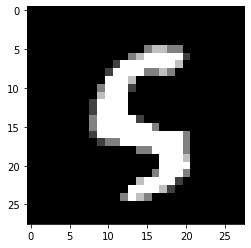

In [186]:
model.eval()
with torch.no_grad():
  for xb, yb in valid_dl:
    ##################
    # Get predict label
    # CODE HERE
    out = model(xb)
    pred = torch.argmax(out, dim=1)
    #
    ##################

    ##################
    # Visualize sample if it is wrong
    # CODE HERE
    if pred != yb:
        print('groundtruth: ', yb.numpy())
        print("prediction: ", pred.numpy())
        print("image:")
        pyplot.imshow(xb[0].numpy().reshape((28,28)), cmap = 'gray')
        break
    #
    ##################